In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy

In [2]:
original_img = cv2.imread("./images/electronics/BBB.jpg")
# original_img = "/usercode/images/electronics/BBB.jpg"

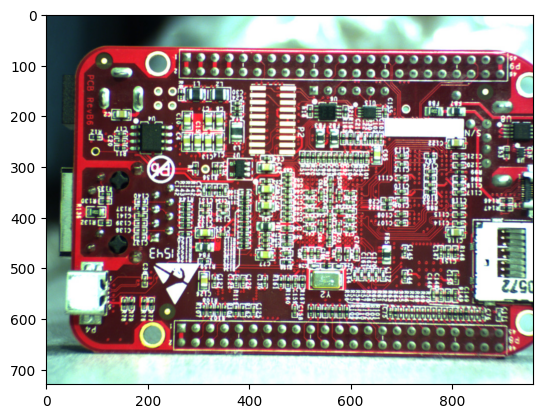

In [3]:
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))

In [4]:
# In a previous exercise, we found the fiducials
fiducial_centers = [(240, 587), (867, 154), (115, 93)]
annotated_img = copy.deepcopy(original_img)
# Draw a circle around the fiducials
for fiducial_center in fiducial_centers:
    cv2.circle(annotated_img, fiducial_center, 35, (255, 0, 0), thickness=4)

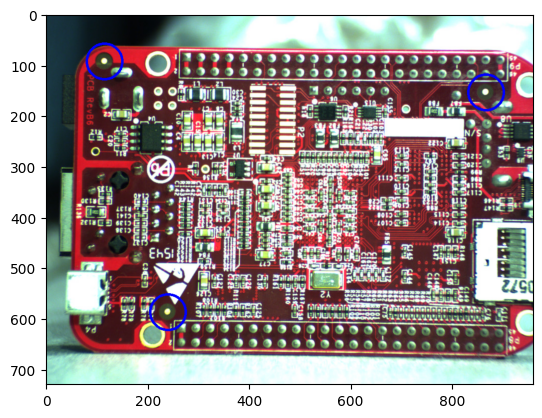

In [5]:
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))

In [6]:
import sys
def north_west(points_list):
    north_west_point = None
    smallest_x_plus_y = sys.maxsize
    for p in points_list:
        x_plus_y = p[0] + p[1]
        if x_plus_y < smallest_x_plus_y:
            smallest_x_plus_y = x_plus_y
            north_west_point = p
    return north_west_point

In [7]:
north_west_fiducial = north_west(fiducial_centers)
print(f"north_west_fiducial = {north_west_fiducial}")

north_west_fiducial = (115, 93)


In [8]:
# The white rectangle containg the connections to inspect is 13.8 millimeters to the right of the North-West fiducial
resolution_in_millimeters_per_pixel = 0.093
distance_from_north_west_fiducial_in_mm = 13.8
rectangle_width_in_mm = 60.0
rectangle_height_in_mm = 5.2

In [9]:
distance_from_north_west_fiducial_in_pixels = round(distance_from_north_west_fiducial_in_mm / resolution_in_millimeters_per_pixel)
rectangle_width_in_pixels = round(rectangle_width_in_mm / resolution_in_millimeters_per_pixel)
rectangle_height_in_pixels = round(rectangle_height_in_mm / resolution_in_millimeters_per_pixel)

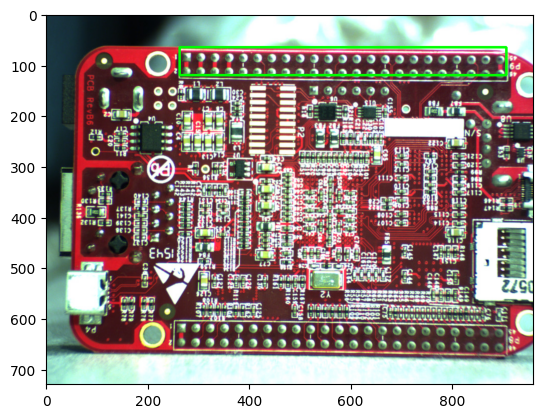

In [10]:
approximate_location_img = copy.deepcopy(original_img)
approximate_rect = (north_west_fiducial[0] + distance_from_north_west_fiducial_in_pixels,
                   north_west_fiducial[1] - rectangle_height_in_pixels//2,
                   rectangle_width_in_pixels, rectangle_height_in_pixels)
cv2.rectangle(approximate_location_img, approximate_rect, (0, 255, 0), thickness=3)
plt.imshow(cv2.cvtColor(approximate_location_img, cv2.COLOR_BGR2RGB))

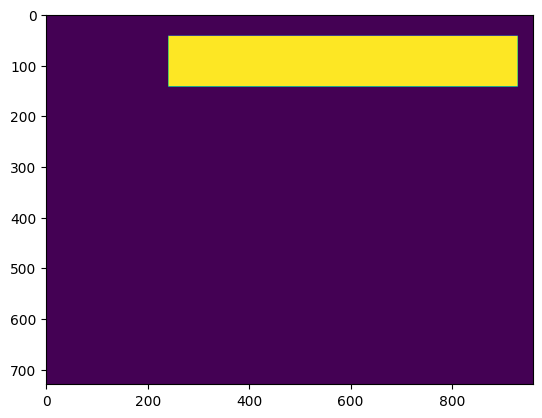

In [11]:
# Create a mask of the area approximate location
inspection_area_mask = np.zeros((original_img.shape[: -1]), dtype=np.uint8)
#print(f"inspection_area_mask.shape = {inspection_area_mask.shape}")
cv2.rectangle(inspection_area_mask, approximate_rect, 255, thickness=-1)
dilation_kernel = np.ones((45, 45), dtype=np.uint8)
inspection_area_mask = cv2.dilate(inspection_area_mask, dilation_kernel)
plt.imshow(inspection_area_mask)

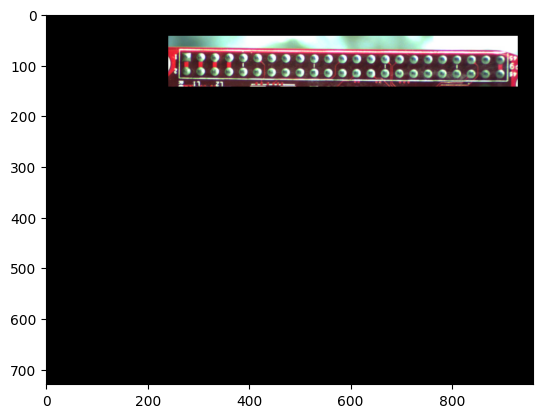

In [12]:
masked_img = np.minimum(original_img, cv2.cvtColor(inspection_area_mask, cv2.COLOR_GRAY2BGR))
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

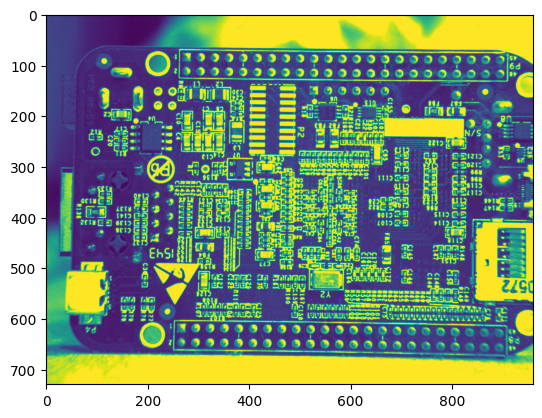

In [13]:
# Find the channel with the best contrast
blue_img, green_img, red_img = cv2.split(original_img)
# We'll use the green channel
plt.imshow(green_img)

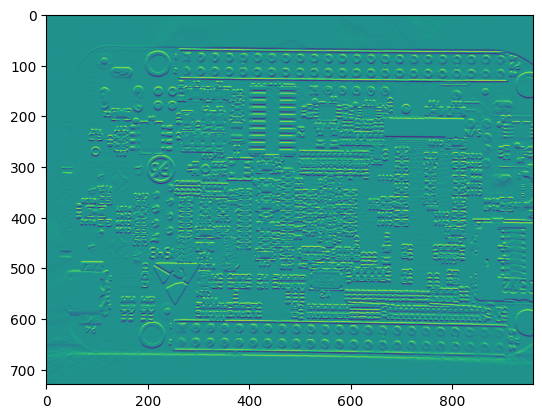

In [14]:
# Sobel edge detection
sobel_y_img = cv2.Sobel(green_img, ddepth=cv2.CV_32F, dx=0, dy=1)
plt.imshow(sobel_y_img)

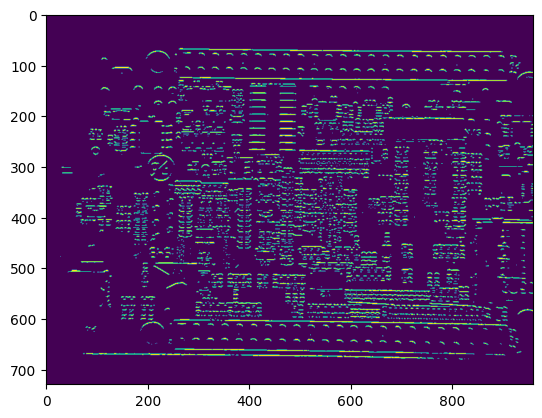

In [15]:
retval, thresholded_sobel_y_img = cv2.threshold(sobel_y_img, 300, 255, cv2.THRESH_BINARY)
plt.imshow(thresholded_sobel_y_img)

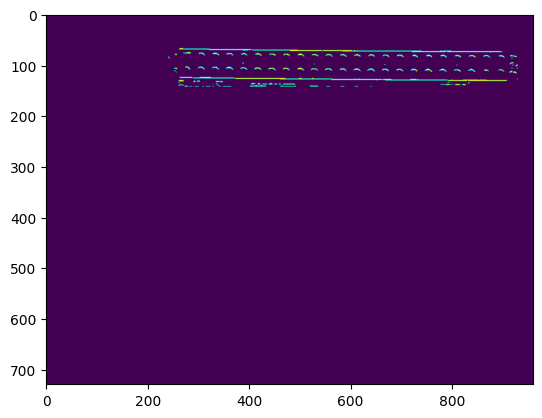

In [16]:
thresholded_sobel_y_img = np.minimum(thresholded_sobel_y_img, inspection_area_mask).astype(np.uint8)
plt.imshow(thresholded_sobel_y_img)

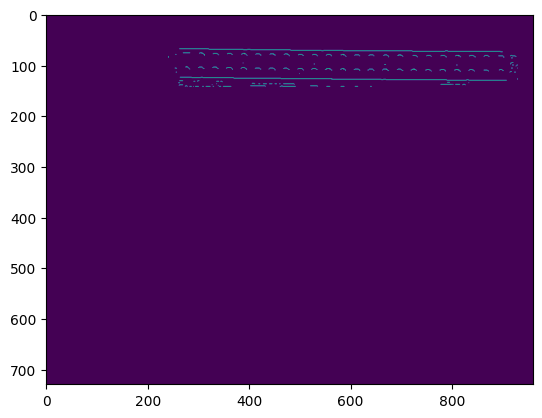

In [17]:
# Thinning
thresholded_sobel_y_img = cv2.ximgproc.thinning(thresholded_sobel_y_img)
plt.imshow(thresholded_sobel_y_img)

In [18]:
# Hough line detection
rho_resolution = 1.0
theta_resolution = 0.01
hough_threshold = 300
print(f"thresholded_sobel_y_img.dtype = {thresholded_sobel_y_img.dtype}")
horizontal_lines = cv2.HoughLines(thresholded_sobel_y_img, rho_resolution, theta_resolution, hough_threshold)
print(f"horizontal_lines = {horizontal_lines}")

thresholded_sobel_y_img.dtype = uint8
horizontal_lines = [[[122.          1.5799999]]

 [[ 66.          1.5799999]]]


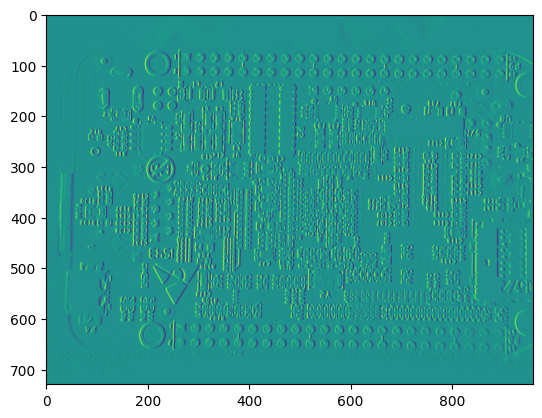

In [19]:
# Sobel edge detection
sobel_x_img = cv2.Sobel(green_img, ddepth=cv2.CV_32F, dx=1, dy=0)
plt.imshow(sobel_x_img)

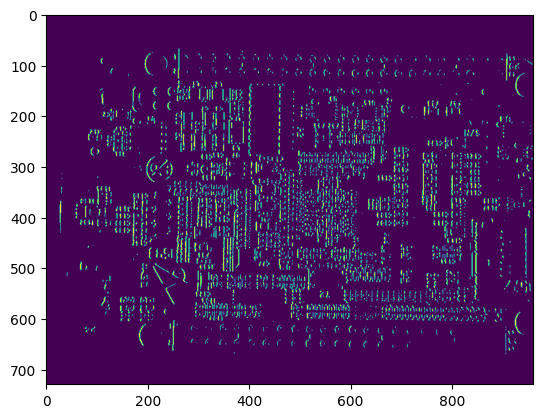

In [20]:
retval, thresholded_sobel_x_img = cv2.threshold(sobel_x_img, 300, 255, cv2.THRESH_BINARY)
plt.imshow(thresholded_sobel_x_img)

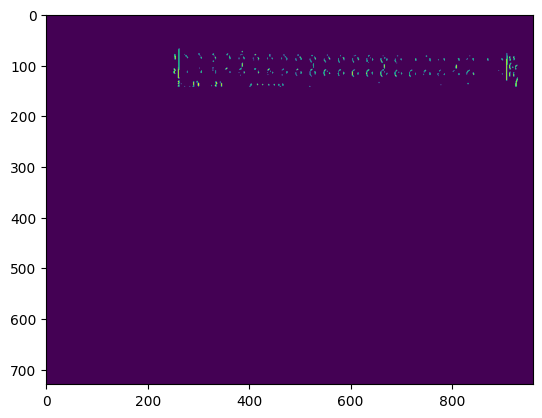

In [21]:
thresholded_sobel_x_img = np.minimum(thresholded_sobel_x_img, inspection_area_mask).astype(np.uint8)
plt.imshow(thresholded_sobel_x_img)

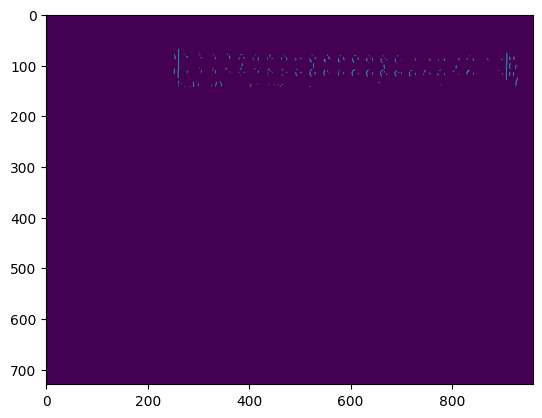

In [22]:
# Thinning
thresholded_sobel_x_img = cv2.ximgproc.thinning(thresholded_sobel_x_img)
plt.imshow(thresholded_sobel_x_img)

In [23]:
# Hough line detection
rho_resolution = 1.0
theta_resolution = 0.01
hough_threshold = 45
vertical_lines = cv2.HoughLines(thresholded_sobel_x_img, rho_resolution, theta_resolution, hough_threshold)
print(f"vertical_lines = {vertical_lines}")

vertical_lines = [[[9.10e+02 3.00e-02]]

 [[2.61e+02 0.00e+00]]

 [[2.62e+02 1.00e-02]]]


In [24]:
import math
def DrawLine(image, rho_theta, color):
    rho = rho_theta[0]
    theta = rho_theta[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = round(x0 - 1000 * b)
    y1 = round(y0 + 1000 * a)
    x2 = round(x0 + 1000 * b)
    y2 = round(y0 - 1000 * a)
    cv2.line(image, (x1, y1), (x2, y2), color=color, thickness=1)

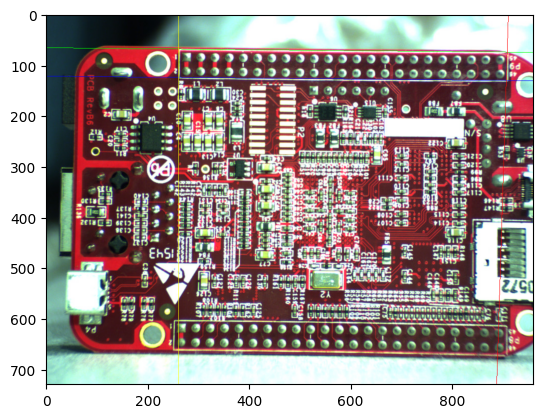

In [25]:
annotated_lines_img = copy.deepcopy(original_img)
DrawLine(annotated_lines_img, horizontal_lines[0][0], (255, 0, 0))
DrawLine(annotated_lines_img, horizontal_lines[1][0], (0, 255, 0))
DrawLine(annotated_lines_img, vertical_lines[0][0], (0, 0, 255))
DrawLine(annotated_lines_img, vertical_lines[1][0], (0, 255, 255))
plt.imshow(cv2.cvtColor(annotated_lines_img, cv2.COLOR_BGR2RGB))